In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from nltk.corpus import stopwords

### Read in Data

In [2]:
nhl_nba_df = pd.read_csv('data/nhl_nba_df.csv')
nhl_nba_df.head()

,Unnamed: 0,title,selftext,label,combo,combo_lem,combo_stem
0,0,What's this I've been hearing about turning NH...,Can someone fill me in on what's going on with...,1,What's this I've been hearing about turning NH...,What's this I've been hearing about turning NH...,what's this i've been hearing about turning nh...
1,1,ELI5: What's this about turning NHL jerseys in...,"I can't watch local games, I can't play the si...",1,ELI5: What's this about turning NHL jerseys in...,ELI5: What's this about turning NHL jerseys in...,eli5: what's this about turning nhl jerseys in...
2,4,Does ESPN+ Currently Have Last Seasons Games?,"Trying to fill the hole in my life, but I don'...",1,Does ESPN+ Currently Have Last Seasons Games?T...,Does ESPN+ Currently Have Last Seasons Games?T...,does espn+ currently have last seasons games?t...
3,14,Do Little League and kids Hickey teams use NHL...,I used to play Hockey in the Little Leagues (P...,1,Do Little League and kids Hickey teams use NHL...,Do Little League and kids Hickey teams use NHL...,do little league and kids hickey teams use nhl...
4,17,About to be a New Yorker and want to get into ...,About to be a New Yorker and want to get into ...,1,About to be a New Yorker and want to get into ...,About to be a New Yorker and want to get into ...,about to be a new yorker and want to get into ...


### Word Counts and Stop Words

In [3]:
#Identify and adding to stop words
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = 'english')
tfidf.fit(nhl_nba_df['combo'])

word_count_df = pd.DataFrame(tfidf.transform(nhl_nba_df['combo']).todense(),
                  columns = tfidf.get_feature_names())

for i in word_count_df.columns:
    word_count_df[i] = word_count_df[i].sum()
    
word_count_df = word_count_df.loc[:0].T.sort_values(0, ascending=False)
word_count_df.head()

,0
removed,89.763221
team,67.763588
nba,64.272403
game,56.096577
player,49.716673


In [4]:
word_count_df.reset_index(inplace=True)
word_count_df.rename(columns={'index':'word', 0:'count'}, inplace=True)
word_count_df.head()

,word,count
0,removed,89.763221
1,team,67.763588
2,nba,64.272403
3,game,56.096577
4,player,49.716673


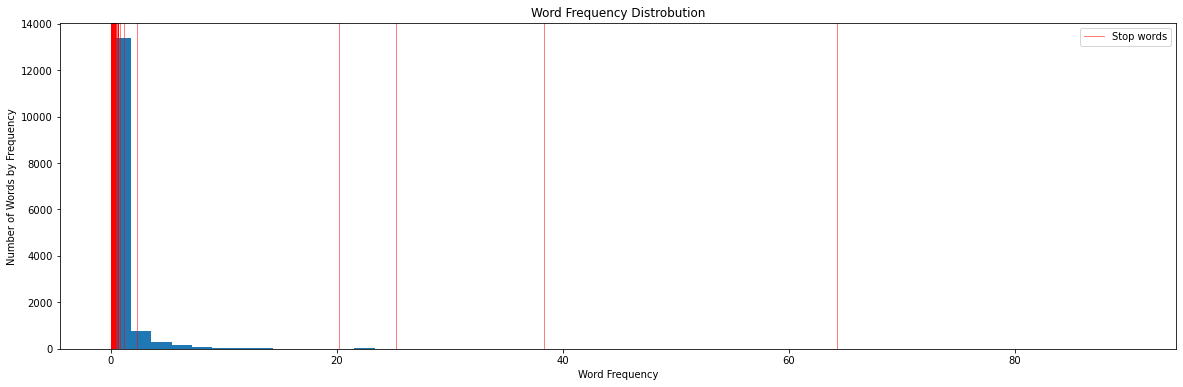

In [5]:
# plt.hist
root_words = ['hockey', 'basketball', 'nba', 'nhl']
custom_stop_words = [w for w in word_count_df.word for i in root_words if i in w]
fig, ax = plt.subplots(figsize = (20,6))
plt.hist(word_count_df['count'], bins=50);
for i in custom_stop_words:
    stopword = word_count_df[word_count_df.word == i]['count'].values
    plt.axvline(stopword, color='red', linewidth=1, alpha=.5)
plt.title('Word Frequency Distrobution')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words by Frequency')
label = ['Stop words']
plt.legend(labels=label);
plt.savefig("distro.png")

In [6]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [7]:
#Add our new NHL and NBA specific 'custom_stop_words' list to the standard NLTK stop words
s_words = stopwords.words('english')
s_words = s_words + custom_stop_words
print(s_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Model

In [8]:
# Create X and y
X = nhl_nba_df['combo']
X_lem = nhl_nba_df['combo_lem']
X_stem = nhl_nba_df['combo_stem']

y = nhl_nba_df['label']

# Whats the baseline score
y.value_counts(normalize=True)

0    0.626667
1    0.373333
Name: label, dtype: float64

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_lem, X_test_lem, y_train, y_test = train_test_split(X_lem, y, random_state=42)
X_train_stem, X_test_stem, y_train, y_test = train_test_split(X_stem, y, random_state=42)

### Model Comparison

In [12]:
tts_list = [[X_train, X_test, y_train, y_test], [X_train_lem, X_test_lem, y_train, y_test], [X_train_stem, X_test_stem, y_train, y_test]]

#### KNN

In [13]:
# Instantiate KNN
knn_pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words=s_words)),
    ('knn', KNeighborsClassifier())
])
# Fit
knn_pipe.fit(X_train, y_train)
# Score
print('No text normalization:')
print('R-Squared Score: ', knn_pipe.score(X_test, y_test))
c_val_scores = cross_val_score(knn_pipe, X_test, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

print('Lemmatization:')
print('R-Squared Score: ', knn_pipe.score(X_test_lem, y_test))
c_val_scores = cross_val_score(knn_pipe, X_test_lem, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

print('Stemming:')
print('R-Squared Score: ', knn_pipe.score(X_test_stem, y_test))
c_val_scores = cross_val_score(knn_pipe, X_test_stem, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

No text normalization:
R-Squared Score:  0.88
Cross Val Scores:  [0.82962963 0.79259259 0.91111111 0.9037037  0.79259259]
Cross Val Mean and Conf. Interval: 0.8459259259259259 ± 0.10408395893481653 

Lemmatization:
R-Squared Score:  0.88
Cross Val Scores:  [0.82962963 0.79259259 0.91111111 0.9037037  0.79259259]
Cross Val Mean and Conf. Interval: 0.8459259259259259 ± 0.10408395893481653 

Stemming:
R-Squared Score:  0.8785185185185185
Cross Val Scores:  [0.82962963 0.8        0.91111111 0.8962963  0.79259259]
Cross Val Mean and Conf. Interval: 0.8459259259259259 ± 0.0980019876061702 



#### Logistic Regression

In [14]:
# Instantiate logistic regression
lr_pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words=s_words)),
    ('lr', LogisticRegression())
])
# Fit
lr_pipe.fit(X_train, y_train)
#Score
print('No text normalization:')
print('R-Squared Score: ', lr_pipe.score(X_test, y_test))
c_val_scores = cross_val_score(lr_pipe, X_test, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

print('Lemmatization:')
print('R-Squared Score: ', lr_pipe.score(X_test_lem, y_test))
c_val_scores = cross_val_score(lr_pipe, X_test_lem, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

print('Stemming:')
print('R-Squared Score: ', lr_pipe.score(X_test_stem, y_test))
c_val_scores = cross_val_score(lr_pipe, X_test_stem, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

No text normalization:
R-Squared Score:  0.8992592592592593
Cross Val Scores:  [0.81481481 0.79259259 0.87407407 0.83703704 0.78518519]
Cross Val Mean and Conf. Interval: 0.8207407407407408 ± 0.06450826979874738 

Lemmatization:
R-Squared Score:  0.8992592592592593
Cross Val Scores:  [0.81481481 0.79259259 0.87407407 0.83703704 0.78518519]
Cross Val Mean and Conf. Interval: 0.8207407407407408 ± 0.06450826979874738 

Stemming:
R-Squared Score:  0.8977777777777778
Cross Val Scores:  [0.81481481 0.79259259 0.88148148 0.83703704 0.78518519]
Cross Val Mean and Conf. Interval: 0.8222222222222222 ± 0.06948764088627304 



#### Random Forest

In [15]:
# Instantiate Random Forest
rf_pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words=s_words)),
    ('lr', RandomForestClassifier())
])
# Fit
rf_pipe.fit(X_train, y_train)
#Score
print('No text normalization:')
print('R-Squared Score: ', rf_pipe.score(X_test, y_test))
c_val_scores = cross_val_score(rf_pipe, X_test, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

print('Lemmatization:')
print('R-Squared Score: ', rf_pipe.score(X_test_lem, y_test))
c_val_scores = cross_val_score(rf_pipe, X_test_lem, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

print('Stemming:')
print('R-Squared Score: ', rf_pipe.score(X_test_stem, y_test))
c_val_scores = cross_val_score(rf_pipe, X_test_stem, y_test)
print('Cross Val Scores: ', c_val_scores)
print('Cross Val Mean and Conf. Interval: {} ± {}'.format(c_val_scores.mean(), 
                                 2 * c_val_scores.std()), '\n')

No text normalization:
R-Squared Score:  0.9214814814814815
Cross Val Scores:  [0.83703704 0.82962963 0.91851852 0.85925926 0.88148148]
Cross Val Mean and Conf. Interval: 0.8651851851851852 ± 0.0645082697987474 

Lemmatization:
R-Squared Score:  0.9214814814814815
Cross Val Scores:  [0.87407407 0.82222222 0.92592593 0.88888889 0.82962963]
Cross Val Mean and Conf. Interval: 0.8681481481481482 ± 0.0769229925081314 

Stemming:
R-Squared Score:  0.9214814814814815
Cross Val Scores:  [0.82962963 0.81481481 0.91851852 0.87407407 0.86666667]
Cross Val Mean and Conf. Interval: 0.8607407407407408 ± 0.0728189969033749 



Random Forest yeilds us our best results of the 3 models. Furthermore TFIDF improves scores just slightly higher than CountVecotrizer. Explore why this is.

Either way we'll use this model to test more in the param_grid.

In [16]:
#Score
param_grid = {
    'vect__binary': [True, False],
    'vect__strip_accents': [None, 'ascii'],
    'vect__max_features': [None, 5000, 10000],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
}
gs = GridSearchCV(rf_pipe, param_grid=param_grid)
gs.fit(X_train_lem, y_train)
print(gs.best_score_)
gs.best_params_

0.9012345679012347


{'vect__binary': False,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1),
 'vect__strip_accents': None}

### Evaluation

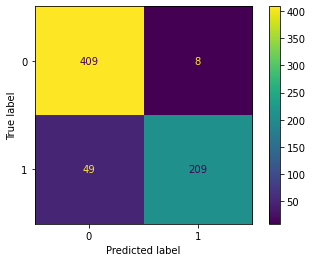

In [20]:
plot_confusion_matrix(gs, X_test_lem, y_test)
plt.savefig("c_matrix.png")

In [18]:
# Generate predictions.

# lr.fit(X_train, y_train)
preds = gs.predict(X_test)

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Print matrix
print(confusion_matrix(y_test, preds))
print(f'tn: {tn}')
print(f'fp: {fp}')
print(f'fn: {fn}')
print(f'tp: {tp}')

[[409   8]
 [ 49 209]]
tn: 409
fp: 8
fn: 49
tp: 209


### Next Steps

- Conitue fine-tuning hyperparameters in the GridSearchCV function
- Explore additional features from the original API request data 
- Examine the words with high predictiveness as well as those contributing to the 49 False-Negative and 8 False-Positive predictions